In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import os
import sys
import time
import logging  # [LOGGING] Importar la librería de logging
import random  # [SEED] Importar la librería random de Python
import numpy as np  # [SEED] Importar NumPy
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm # Para barra de progreso
from prettytable import PrettyTable # Para tabla de parámetros (pip install prettytable)

# Importar tu modelo corregido (asegúrate de que el archivo .py esté en la carpeta)
sys.path.append("KAN_models")
from SBTAYLOR_KAN import Net as KAN_Model 
from DR_SBTAYLOR_KAN import DeepTaylorKAN as DeepTaylorKAN_Model

# Configuración de Dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Semilla
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

Usando dispositivo: cuda


In [2]:
weights_tiny_imagenet = "models\\sbtaylor_kan_tiny_imagenet\\run_20251224_013331\\best_model.pth"


In [3]:
COTTON_PATH = "./processed_dataset"
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

RUN_SAVE_DIR = os.path.join("models/sbtaylor_kan_cotton", f"run_{timestamp}")
os.makedirs(RUN_SAVE_DIR, exist_ok=True)

MODEL_NAME = "sbtaylor_kan.best_weights.pth"
MODEL_SAVE_PATH = os.path.join(RUN_SAVE_DIR, MODEL_NAME)

In [4]:
LOG_FILE_PATH = os.path.join(RUN_SAVE_DIR, "training_run.log")

In [5]:
# --- [LOGGING] CONFIGURACIÓN DEL LOGGER ---
# Configura el logger para que escriba en un archivo y en la consola.
logging.basicConfig(
    level=logging.INFO,  # Nivel mínimo de mensajes a registrar (INFO, WARNING, ERROR)
    format="%(asctime)s - %(levelname)s - %(message)s",  # Formato del mensaje
    handlers=[
        logging.FileHandler(
            LOG_FILE_PATH, mode="w"
        ),  # Escribe en el archivo .log (modo 'w' para sobreescribir en cada ejecución)
        logging.StreamHandler(),  # Muestra los logs en la consola
    ],
)

# Ahora, en lugar de print(), usaremos logging.info()
logger = logging.getLogger()

logger.info("Modelo SBTAYLOR_KAN.Net importado correctamente.")
logger.info(f"Los pesos del modelo se guardarán en: '{MODEL_SAVE_PATH}'")
logger.info(f"El registro de entrenamiento se guardará en: '{LOG_FILE_PATH}'")

2025-12-24 15:05:36,756 - INFO - Modelo SBTAYLOR_KAN.Net importado correctamente.
2025-12-24 15:05:36,758 - INFO - Los pesos del modelo se guardarán en: 'models/sbtaylor_kan_cotton\run_20251224_150536\sbtaylor_kan.best_weights.pth'
2025-12-24 15:05:36,759 - INFO - El registro de entrenamiento se guardará en: 'models/sbtaylor_kan_cotton\run_20251224_150536\training_run.log'


In [6]:
logger.info(f"Versión de PyTorch: {torch.__version__}")
logger.info(f"¿CUDA está disponible?: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    logger.info(
        f"Versión de CUDA con la que PyTorch fue compilado: {torch.version.cuda}"
    )
    logger.info(f"Número de GPUs disponibles: {torch.cuda.device_count()}")
    logger.info(f"Nombre de la GPU actual: {torch.cuda.get_device_name(0)}")
else:
    logger.info(
        "PyTorch no puede encontrar CUDA. Es probable que hayas instalado la versión de solo CPU."
    )

2025-12-24 15:05:36,783 - INFO - Versión de PyTorch: 2.9.0+cu126
2025-12-24 15:05:36,784 - INFO - ¿CUDA está disponible?: True
2025-12-24 15:05:36,785 - INFO - Versión de CUDA con la que PyTorch fue compilado: 12.6
2025-12-24 15:05:36,786 - INFO - Número de GPUs disponibles: 1
2025-12-24 15:05:36,790 - INFO - Nombre de la GPU actual: NVIDIA GeForce RTX 4090


In [7]:
# --- 2. PARÁMETROS DE ENTRENAMIENTO ---
set_seed(42)  # [SEED] Establecer la semilla para reproducibilidad
BATCH_SIZE = 64
NUM_EPOCHS = 150
LEARNING_RATE = 1e-4

# print hyperparameters
logging.info(f"--- Hyperparámetros de Entrenamiento ---")
logging.info(f"Batch Size: {BATCH_SIZE}")
logging.info(f"Num Epochs: {NUM_EPOCHS}")
logging.info(f"Learning Rate: {LEARNING_RATE}")

2025-12-24 15:05:36,818 - INFO - --- Hyperparámetros de Entrenamiento ---
2025-12-24 15:05:36,819 - INFO - Batch Size: 64
2025-12-24 15:05:36,820 - INFO - Num Epochs: 150
2025-12-24 15:05:36,821 - INFO - Learning Rate: 0.0001


In [8]:
# --- 3. PREPARACIÓN DEL DATASET IMAGENET ---
# (El código interno no cambia, solo los prints)
transform_train = transforms.Compose([
    # 1. Zoom y Recorte Aleatorio: Simula diferentes distancias de la cámara
    # Toma un área de entre el 80% y 100% de la hoja y la estira a 224x224
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    
    # 2. Rotación Total: Las hojas pueden estar en cualquier ángulo
    transforms.RandomRotation(degrees=180), 
    
    # 3. Flips: Muy efectivos para hojas
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    
    # 4. Jitter de Color: Vital para cambios de luz en el campo
    # Varía brillo, contraste y saturación sutilmente
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    
    # 5. Transformaciones finales obligatorias
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
transform_val = transforms.Compose(
    [
        transforms.Resize(256), # Redimensionar para validación
        transforms.CenterCrop(224), # Recorte central
        transforms.ToTensor(), # Convertir a tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalización
    ]
)

logger.info(f"\nCargando dataset de {COTTON_PATH}...")
if not os.path.isdir(COTTON_PATH):
    logger.error(f"Error: La ruta de ('{COTTON_PATH}') no es válida.")
    sys.exit(1)

train_dataset = datasets.ImageFolder(
    root=os.path.join(COTTON_PATH, "train"), transform=transform_train
)
val_dataset = datasets.ImageFolder(
    root=os.path.join(COTTON_PATH, "val"), transform=transform_val
)


dataloaders = {
    'train': DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True),
    'val': DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
}

dataset_sizes = {x: len(dataloaders[x].dataset) for x in ['train', 'val']}
class_names = train_dataset.classes
logger.info(f"Clases detectadas: {class_names}")

2025-12-24 15:05:36,854 - INFO - 
Cargando dataset de ./processed_dataset...
2025-12-24 15:05:36,878 - INFO - Clases detectadas: ['Aphids', 'Army worm', 'Bacterial Blight', 'Healthy', 'Powdery Mildew', 'Target spot']


In [9]:
# --- 4. INICIALIZACIÓN DEL MODELO, CRITERIO Y OPTIMIZADOR ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(f"\nUsando dispositivo: {device}")

2025-12-24 15:05:36,891 - INFO - 
Usando dispositivo: cuda


In [10]:
# 1. Instancia tu modelo con las clases de TU problema actual (Algodón = 6)
num_classes_cotton = len(class_names) # Asumo que esto es 6
model_ft = KAN_Model(num_classes=num_classes_cotton).to(device)

# 2. Cargar el diccionario de pesos original
pretrained_dict = torch.load(weights_tiny_imagenet)

# 3. Obtener el diccionario de pesos del modelo actual
model_dict = model_ft.state_dict()

# -----------------------------------------------------------
# PASO CRÍTICO: FILTRADO DE PESOS
# -----------------------------------------------------------
# Vamos a filtrar los pesos, quedándonos solo con aquellos que:
# 1. Existan en el modelo actual.
# 2. Tengan el mismo tamaño (shape) que en el modelo actual.
# Esto eliminará automáticamente 'fc3.weight', 'fc3.bias', etc.
pretrained_dict = {
    k: v for k, v in pretrained_dict.items() 
    if k in model_dict and v.shape == model_dict[k].shape
}

# 4. Actualizar el diccionario del modelo actual con los pesos filtrados
model_dict.update(pretrained_dict)

# 5. Cargar el diccionario final en el modelo
# Usamos strict=True porque ya hemos filtrado manualmente lo que no sirve
model_ft.load_state_dict(model_dict)

print(f"✅ Pesos cargados correctamente. Se ignoraron las capas incompatibles (fc3).")
print(f"Capas cargadas: {len(pretrained_dict)} de {len(model_dict)}")

# 6. Verificar
from torchsummary import summary
summary(model_ft, (3, 224, 224))

Dimensiones calculadas automáticamente para FC1: 25088
✅ Pesos cargados correctamente. Se ignoraron las capas incompatibles (fc3).
Capas cargadas: 38 de 41
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 128, 14, 14]         --
|    └─Conv2d: 2-1                       [-1, 32, 224, 224]        896
|    └─BatchNorm2d: 2-2                  [-1, 32, 224, 224]        64
|    └─ReLU: 2-3                         [-1, 32, 224, 224]        --
|    └─MaxPool2d: 2-4                    [-1, 32, 112, 112]        --
|    └─Conv2d: 2-5                       [-1, 64, 112, 112]        18,496
|    └─BatchNorm2d: 2-6                  [-1, 64, 112, 112]        128
|    └─ReLU: 2-7                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-8                    [-1, 64, 56, 56]          --
|    └─Conv2d: 2-9                       [-1, 128, 56, 56]         73,856
|    └─BatchNorm2d: 2-10                 [-1, 128, 56, 56] 

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 128, 14, 14]         --
|    └─Conv2d: 2-1                       [-1, 32, 224, 224]        896
|    └─BatchNorm2d: 2-2                  [-1, 32, 224, 224]        64
|    └─ReLU: 2-3                         [-1, 32, 224, 224]        --
|    └─MaxPool2d: 2-4                    [-1, 32, 112, 112]        --
|    └─Conv2d: 2-5                       [-1, 64, 112, 112]        18,496
|    └─BatchNorm2d: 2-6                  [-1, 64, 112, 112]        128
|    └─ReLU: 2-7                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-8                    [-1, 64, 56, 56]          --
|    └─Conv2d: 2-9                       [-1, 128, 56, 56]         73,856
|    └─BatchNorm2d: 2-10                 [-1, 128, 56, 56]         256
|    └─ReLU: 2-11                        [-1, 128, 56, 56]         --
|    └─MaxPool2d: 2-12                   [-1, 128, 28, 28]         --
|   

In [11]:
import copy
import os
import torch
import time
import numpy as np
from tqdm import tqdm # Barra de progreso

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, output_dir, logger, scheduler=None):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    # --- CONFIGURACIÓN DE EARLY STOPPING ---
    patience = 10
    patience_counter = 0
    min_val_loss = np.inf  # Empezamos con pérdida infinita
    early_stop = False
    # ---------------------------------------
    
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    logger.info(f"Iniciando entrenamiento por {num_epochs} épocas...")
    logger.info(f"Paciencia configurada: {patience} épocas.")

    for epoch in range(num_epochs):
        if early_stop:
            break  # Salir del bucle de épocas
            
        logger.info(f'--- Época {epoch+1}/{num_epochs} ---')

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0
            
            loop = tqdm(dataloader, desc=f"{phase.capitalize()}", leave=False)

            for inputs, labels in loop:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                loop.set_postfix(loss=loss.item())

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

                # --- LÓGICA DEL SCHEDULER ---
                if scheduler is not None:
                    # El scheduler ReduceLROnPlateau necesita la pérdida de validación
                    scheduler.step(epoch_loss)
                    # Log del Learning Rate actual para ver cuándo baja
                    current_lr = optimizer.param_groups[0]['lr']
                    logger.info(f"  [LR] Tasa de aprendizaje actual: {current_lr:.6f}")

                # --- LÓGICA DE EARLY STOPPING (Basada en Pérdida de Validación) ---
                if epoch_loss < min_val_loss:
                    logger.info(f"  [Mejora Loss] {min_val_loss:.4f} -> {epoch_loss:.4f}. Reseteando paciencia.")
                    min_val_loss = epoch_loss
                    patience_counter = 0  # Hubo mejora, reseteamos el contador
                else:
                    patience_counter += 1
                    logger.info(f"  [Sin mejora Loss] Paciencia: {patience_counter}/{patience}")
                    if patience_counter >= patience:
                        logger.info("¡EARLY STOPPING ACTIVADO! El modelo ya no mejora su pérdida.")
                        early_stop = True
                # -----------------------------------------------------------------

            logger.info(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Guardar el mejor modelo basado en ACCURACY (independiente del Early Stopping)
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                save_path = os.path.join(output_dir, 'best_model.pth')
                torch.save(model.state_dict(), save_path)
                logger.info(f"  [Nuevo Récord Acc] Guardado en: {save_path}")

    time_elapsed = time.time() - since
    logger.info(f'Entrenamiento finalizado en {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    logger.info(f'Mejor Val Acc lograda: {best_acc:.4f}')

    # Cargar los mejores pesos encontrados
    model.load_state_dict(best_model_wts)
    
    last_path = os.path.join(output_dir, 'last_model.pth')
    torch.save(model.state_dict(), last_path)
    
    return model, history



criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_ft.parameters(), lr=1e-4, weight_decay=5e-2)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5,     # Lo reduce a la mitad
    patience=5,     # Si en 5 épocas el val_loss no baja, reduce el LR
)

# Entrenar
model_ft, history = train_model(
    model=model_ft,
    train_loader=dataloaders['train'], # Asume que ya definiste tus dataloaders
    val_loader=dataloaders['val'],
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=NUM_EPOCHS,
    device=device,
    output_dir=RUN_SAVE_DIR, # <--- Aquí se guardarán los .pth
    logger=logger,
    scheduler=scheduler
)

2025-12-24 15:05:38,333 - INFO - Iniciando entrenamiento por 150 épocas...
2025-12-24 15:05:38,335 - INFO - Paciencia configurada: 10 épocas.
2025-12-24 15:05:38,336 - INFO - --- Época 1/150 ---
2025-12-24 15:06:20,773 - INFO - Train Loss: 1.7801 Acc: 0.2322  
2025-12-24 15:06:23,518 - INFO -   [LR] Tasa de aprendizaje actual: 0.000100
2025-12-24 15:06:23,518 - INFO -   [Mejora Loss] inf -> 1.6758. Reseteando paciencia.
2025-12-24 15:06:23,519 - INFO - Val Loss: 1.6758 Acc: 0.3221
2025-12-24 15:06:23,919 - INFO -   [Nuevo Récord Acc] Guardado en: models/sbtaylor_kan_cotton\run_20251224_150536\best_model.pth
2025-12-24 15:06:23,920 - INFO - --- Época 2/150 ---
2025-12-24 15:07:07,754 - INFO - Train Loss: 1.5958 Acc: 0.3383  
2025-12-24 15:07:10,553 - INFO -   [LR] Tasa de aprendizaje actual: 0.000100
2025-12-24 15:07:10,554 - INFO -   [Mejora Loss] 1.6758 -> 1.4696. Reseteando paciencia.
2025-12-24 15:07:10,555 - INFO - Val Loss: 1.4696 Acc: 0.4510
2025-12-24 15:07:11,077 - INFO -   [Nu

In [12]:
from torchsummary import summary
summary(model_ft, (3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 128, 14, 14]         --
|    └─Conv2d: 2-1                       [-1, 32, 224, 224]        896
|    └─BatchNorm2d: 2-2                  [-1, 32, 224, 224]        64
|    └─ReLU: 2-3                         [-1, 32, 224, 224]        --
|    └─MaxPool2d: 2-4                    [-1, 32, 112, 112]        --
|    └─Conv2d: 2-5                       [-1, 64, 112, 112]        18,496
|    └─BatchNorm2d: 2-6                  [-1, 64, 112, 112]        128
|    └─ReLU: 2-7                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-8                    [-1, 64, 56, 56]          --
|    └─Conv2d: 2-9                       [-1, 128, 56, 56]         73,856
|    └─BatchNorm2d: 2-10                 [-1, 128, 56, 56]         256
|    └─ReLU: 2-11                        [-1, 128, 56, 56]         --
|    └─MaxPool2d: 2-12                   [-1, 128, 28, 28]         --
|   

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 128, 14, 14]         --
|    └─Conv2d: 2-1                       [-1, 32, 224, 224]        896
|    └─BatchNorm2d: 2-2                  [-1, 32, 224, 224]        64
|    └─ReLU: 2-3                         [-1, 32, 224, 224]        --
|    └─MaxPool2d: 2-4                    [-1, 32, 112, 112]        --
|    └─Conv2d: 2-5                       [-1, 64, 112, 112]        18,496
|    └─BatchNorm2d: 2-6                  [-1, 64, 112, 112]        128
|    └─ReLU: 2-7                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-8                    [-1, 64, 56, 56]          --
|    └─Conv2d: 2-9                       [-1, 128, 56, 56]         73,856
|    └─BatchNorm2d: 2-10                 [-1, 128, 56, 56]         256
|    └─ReLU: 2-11                        [-1, 128, 56, 56]         --
|    └─MaxPool2d: 2-12                   [-1, 128, 28, 28]         --
|   

Gráfica guardada en: models/sbtaylor_kan_cotton\run_20251224_150536\training_history.png


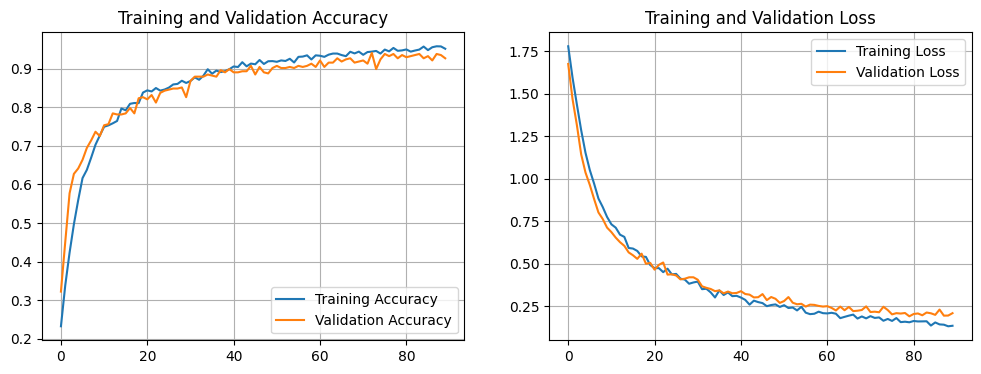

In [13]:
def plot_training_history(history):
    acc = history['train_acc']
    val_acc = history['val_acc']
    loss = history['train_loss']
    val_loss = history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 4))
    
    # Gráfica de Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.grid(True)

    # Gráfica de Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.grid(True)
    # --- CORRECCIÓN AQUÍ ---
    # 1. Guardar PRIMERO
    save_path = os.path.join(RUN_SAVE_DIR, "training_history.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight') # dpi=300 para alta calidad, bbox_inches corta bordes blancos extra
    print(f"Gráfica guardada en: {save_path}")
    
    # 2. Mostrar DESPUÉS
    plt.show()

    
plot_training_history(history)

In [14]:
import numpy as np
import time
import torch
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import logging # Necesario para el type hinting o manejo interno

def evaluate_model(model, test_loader, device, class_names, output_dir, logger):
    """
    Evalúa un modelo entrenado y genera reporte.
    Ahora recibe 'logger' como argumento para asegurar que escriba en tu archivo .log.
    """
    logger.info("\n" + "="*40)
    logger.info("--- INICIANDO EVALUACIÓN EN TEST SET ---")
    logger.info("="*40)

    # 1. Poner el modelo en modo de evaluación (Apaga Dropout/BatchNorm)
    model.eval()

    all_labels = []
    all_preds = []
    
    total_inference_time = 0.0
    total_samples = 0

    # 2. Iterar sobre el conjunto de prueba
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # --- BLOQUE DE MEDICIÓN DE TIEMPO PRECISA ---
            # Si usas GPU, es obligatorio sincronizar antes y después del forward
            if device.type == 'cuda':
                torch.cuda.synchronize()
            
            start_time = time.time()
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            if device.type == 'cuda':
                torch.cuda.synchronize()
            
            end_time = time.time()
            # ---------------------------------------------
            
            # Acumular tiempo real de procesamiento
            total_inference_time += (end_time - start_time)
            total_samples += inputs.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Convertir a numpy
    true_labels = np.array(all_labels)
    predicted_labels = np.array(all_preds)

    # 3. Calcular Métricas
    logger.info("Calculando métricas estadísticas...")
    
    accuracy = accuracy_score(true_labels, predicted_labels)
    
    # zero_division=0 evita errores si una clase no tiene predicciones
    precision_per_class = precision_score(true_labels, predicted_labels, average=None, zero_division=0)
    recall_per_class = recall_score(true_labels, predicted_labels, average=None, zero_division=0)
    f1_per_class = f1_score(true_labels, predicted_labels, average=None, zero_division=0)
    
    # Promedios Macro (trata todas las clases igual, útil si hay desbalance)
    avg_precision = np.mean(precision_per_class)
    avg_recall = np.mean(recall_per_class)
    avg_f1 = np.mean(f1_per_class)

    # Tiempo promedio por imagen (Métrica Clave para KAN vs VGG)
    avg_inference_time_ms = (total_inference_time / total_samples) * 1000 

    # 4. Matriz de Confusión Visual
    logger.info("Generando matriz de confusión...")
    cm = confusion_matrix(true_labels, predicted_labels)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d", # 'd' es para enteros (decimal), mejor que 'g' para conteos
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.xlabel("Predicción del Modelo", fontsize=12)
    plt.ylabel("Realidad (Ground Truth)", fontsize=12)
    plt.title(f"Matriz de Confusión - Accuracy: {accuracy:.2%}", fontsize=14)
    
    cm_path = os.path.join(output_dir, "confusion_matrix.png")
    plt.tight_layout()
    plt.savefig(cm_path)
    plt.close() # Cierra la figura para liberar memoria
    logger.info(f"Gráfico guardado en: {cm_path}")

    # 5. Reporte de Texto
    logger.info("Escribiendo reporte final...")
    
    metrics_df = pd.DataFrame({
        "Clase": class_names,
        "Precision": np.round(precision_per_class, 4),
        "Recall": np.round(recall_per_class, 4),
        "F1-Score": np.round(f1_per_class, 4),
    })

    report_path = os.path.join(output_dir, "test_metrics_report.txt")
    
    with open(report_path, "w", encoding='utf-8') as f:
        f.write("="*50 + "\n")
        f.write(f" REPORTE DE EVALUACIÓN: {time.strftime('%Y-%m-%d %H:%M')}\n")
        f.write("="*50 + "\n\n")
        
        f.write(f"Métricas Globales:\n")
        f.write(f"- Accuracy:          {accuracy:.4f} ({accuracy:.2%})\n")
        f.write(f"- Macro Precision:   {avg_precision:.4f}\n")
        f.write(f"- Macro Recall:      {avg_recall:.4f}\n")
        f.write(f"- Macro F1-Score:    {avg_f1:.4f}\n\n")
        
        f.write("-" * 30 + "\n")
        f.write("EFICIENCIA (Velocidad)\n")
        f.write("-" * 30 + "\n")
        f.write(f"- Muestras totales:  {total_samples}\n")
        f.write(f"- Tiempo total:      {total_inference_time:.4f} seg\n")
        f.write(f"- Tiempo por imagen: {avg_inference_time_ms:.4f} ms\n\n")
        
        f.write("-" * 30 + "\n")
        f.write("DETALLE POR CLASE\n")
        f.write("-" * 30 + "\n")
        # Usamos to_markdown si pandas es reciente, sino to_string
        try:
            f.write(metrics_df.to_markdown(index=False))
        except:
            f.write(metrics_df.to_string(index=False))
        
        f.write("\n\n")
        f.write("Matriz de Confusión (Texto):\n")
        f.write(np.array2string(cm, separator=', '))
        
    logger.info(f"Reporte de texto guardado en: {report_path}")
    logger.info("--- EVALUACIÓN FINALIZADA ---")
    
    return accuracy, avg_f1 # Retorna valores por si los necesitas en el script principal

In [16]:
test_dir = "processed_dataset/test" # <--- Ruta a la carpeta de prueba
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform_val)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

In [17]:
MODEL_SAVE_PATH = os.path.join(RUN_SAVE_DIR, 'best_model.pth')
# 2. Crear una nueva instancia del modelo y cargar los mejores pesos
logger.info("Cargando el mejor modelo para la evaluación...")
eval_model = KAN_Model(num_classes=num_classes_cotton).to(device)
eval_model.load_state_dict(torch.load(MODEL_SAVE_PATH))
class_names = test_dataset.classes  # Obtener los nombres de las clases desde el dataset de prueba
class_names

2025-12-24 16:52:55,257 - INFO - Cargando el mejor modelo para la evaluación...


Dimensiones calculadas automáticamente para FC1: 25088


['Aphids',
 'Army worm',
 'Bacterial Blight',
 'Healthy',
 'Powdery Mildew',
 'Target spot']

In [18]:
# 3. Llamar a la función de evaluación
# Suponiendo que tienes un 'test_loader' y un 'RUN_DIR' definidos
evaluate_model(
    model=eval_model,
    
    test_loader=test_loader,
    device=device,
    class_names=class_names,
    output_dir=RUN_SAVE_DIR, # El directorio de la ejecución actual para guardar los resultados
    logger=logger
)

2025-12-24 16:52:56,944 - INFO - 
2025-12-24 16:52:56,945 - INFO - --- INICIANDO EVALUACIÓN EN TEST SET ---
2025-12-24 16:52:56,947 - INFO - ========================================
2025-12-24 16:53:02,509 - INFO - Calculando métricas estadísticas...
2025-12-24 16:53:02,517 - INFO - Generando matriz de confusión...
2025-12-24 16:53:02,888 - INFO - Gráfico guardado en: models/sbtaylor_kan_cotton\run_20251224_150536\confusion_matrix.png
2025-12-24 16:53:02,890 - INFO - Escribiendo reporte final...
2025-12-24 16:53:02,901 - INFO - Reporte de texto guardado en: models/sbtaylor_kan_cotton\run_20251224_150536\test_metrics_report.txt
2025-12-24 16:53:02,902 - INFO - --- EVALUACIÓN FINALIZADA ---


(0.9301675977653632, np.float64(0.9306996544007128))